In [1]:
import pandas as pd                             #data set handling
import numpy as np                              #math functions
import matplotlib.pyplot as plt                 #plotting
from matplotlib.ticker import NullFormatter     #formatting for plot axes
from scipy.stats import gaussian_kde            #scatter plot density coloring
from scipy.optimize import curve_fit            #distribution fitting

In [2]:
filename = 'rmsd.tc5b.ref_native.2-19.bb.dat'
fpns = 5 #frames per nanosecond, converts frame number to time

box_width = 100 #the size of the box will be 2N + 1 frames, with the box flanking the center frame by this many frames on either side

fit_guess = [1.5, 600, 1, 5, 300, 2] #[mean, peakheight, stdev, ... and repeat for each peak in fit]

In [3]:
df = pd.read_csv(filename, delim_whitespace=True) #dataframe read from the file csv, with delimited whitespaces
df.columns = ['time','rmsd'] # sets the column headers for the dataframe
df['time'] = df['time'] / fpns #fixes the time column to actual time, rather than frames


#this is where the boxcar happens - nan values are so that the boxcar values x&y match the base
rmsd = np.array(df['rmsd'])   #put it into a np array because pandas is slow af
boxed = [np.nan] * box_width  #pad the results with nan values
for i in range(box_width, rmsd.size - box_width):
    boxed.append(rmsd[i - box_width:i + box_width + 1].mean()) #boxcar, moving boxcar by 1 each time
for i in range(0, box_width):
    boxed.append(np.nan)      #pad the ends with more nan
df['boxed'] = boxed           #add the results to the DataFrame

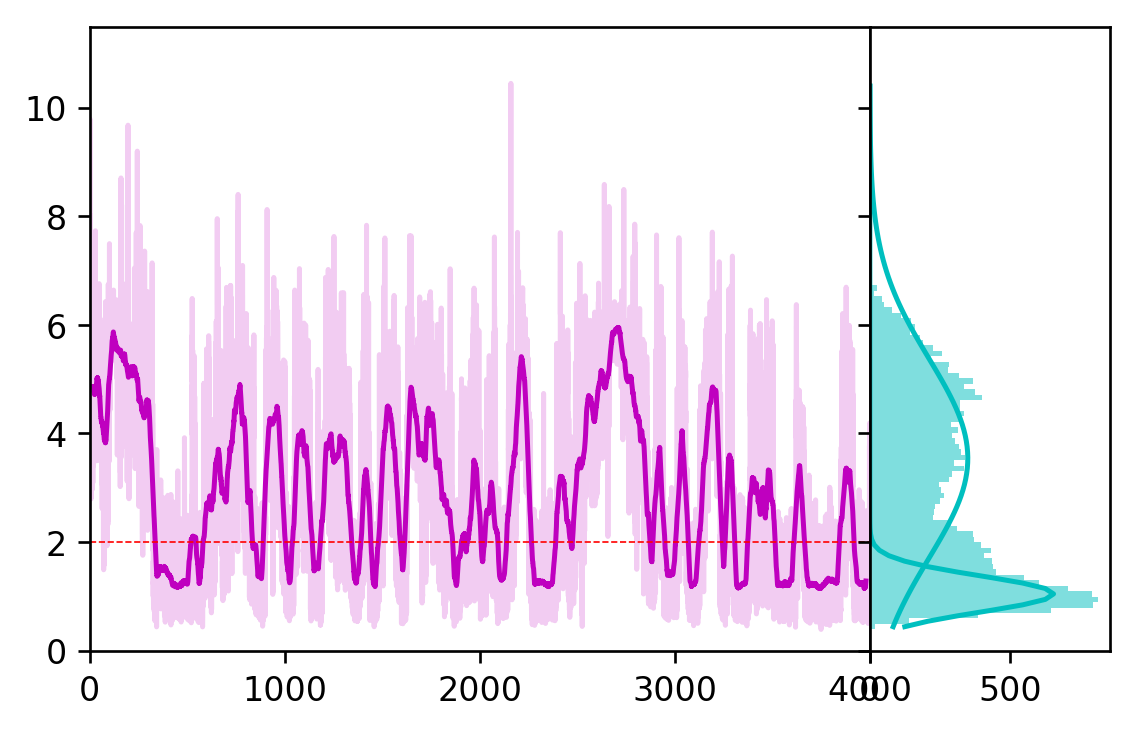

    mean: 1.0442141751910687
  height: 653.3765405719298
   stdev: 0.3309019621738945
    area: 541.9587960684054
rel.area: 25.32800868591317% 

    mean: 3.5402785388294618
  height: 348.43830641651766
   stdev: 1.8293368039945332
    area: 1597.8019833482172
rel.area: 74.67199131408684% 



In [4]:
def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp(-((x - ctr)/ np.sqrt(2) / wid)**2)
    return y

def fit_histo(data_list, bin_num, guess):    
    y, x_ = np.histogram(data_list, bins = bin_num)
    x = []
    for i in range(0, len(x_) - 1):
        x.append(((x_[i + 1] - x_[i]) / 2) + x_[i])
    #guess = [-80, 20, 20, -110, 25, 20] [mean, height, stdev]
    popt, pcov = curve_fit(func, x, y, p0=guess)
    fit = func(x, *popt)
    fit_set = []
    for i in range(0, int(len(guess) / 3)):
        params = [popt[3 * i], popt[3 * i + 1], popt[3 * i + 2]]
        fit_set.append(func(x, *params))
    return [popt, x, fit_set]

x = df['time']
y = df['rmsd']

binsy = 100   #adjust the number of bins for each histogram

xlim = [0, df['time'].max()]   #axes limits
ylim = [0, df['rmsd'].max() * 1.1]

# if you want to draw dashed lines across the plot parallel to either axis
xlines = [] 
ylines = []

#guesses for histogram fitting
guessy = fit_guess

nullfmt = NullFormatter()

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width 

b = 0.2 # how tall the histograms are relative to the plot
rect_plot = [left, bottom, width, height]
rect_histy = [left_h, bottom, b, height]

# start with a rectangular Figure
plt.figure(1, figsize=(5, 4), dpi = 240)
axPlot = plt.axes(rect_plot)
axHisty = plt.axes(rect_histy)

# no y axis labels on histy, labels bad
axHisty.yaxis.set_major_formatter(nullfmt)

# the rmsd plot:
axPlot.plot(df['time'], df['rmsd'], c='m', alpha=0.2)
axPlot.plot(df['time'], df['boxed'], c='m')

axPlot.set_xlim((xlim[0],xlim[1]))
axPlot.set_ylim((ylim[0],ylim[1]))

axHisty.hist(y, bins=binsy, orientation='horizontal', color='c', alpha=0.5)

if len(guessy) > 0:
    axHisty_fit = fit_histo(y, binsy, guessy)
    for fx in axHisty_fit[2]:
        axHisty.plot(fx, axHisty_fit[1], c='c')

axHisty.set_ylim(axPlot.get_ylim())
axPlot.axhline(2,color="red",linewidth=.5,linestyle="--")
plt.show()

if len(guessy) > 0:
    y_stats = []
    total_area = 0
    for i in range(0, len(axHisty_fit[0]), 3):
        temp = []
        temp.append(axHisty_fit[0][i])
        temp.append(axHisty_fit[0][i + 1])
        temp.append(axHisty_fit[0][i + 2])
        area = 2 * np.sqrt(2 * np.log(2)) * axHisty_fit[0][i + 2] * axHisty_fit[0][i + 1] * 1.0645 
        temp.append(area)
        total_area += area
        y_stats.append(temp)
    for stat in y_stats:
        print('    mean:', str(stat[0]))
        print('  height:', str(stat[1]))
        print('   stdev:', str(stat[2]))
        print('    area:', str(stat[3])),
        print('rel.area:', str(stat[3] / total_area * 100) + '%', '\n')

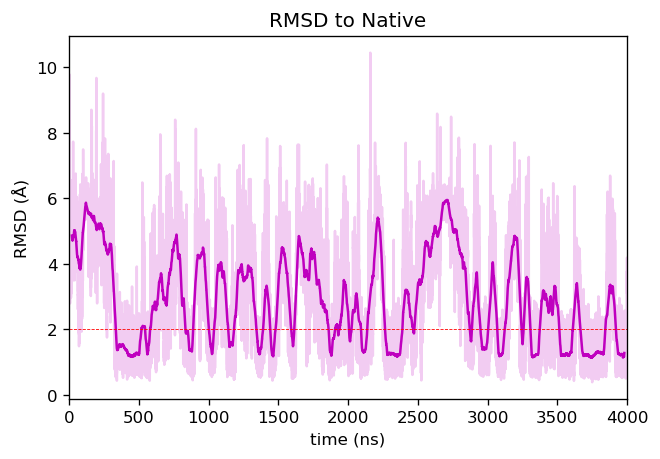

In [5]:
plt.figure(dpi=120)
plt.title('RMSD to Native')
plt.xlabel('time (ns)')
plt.ylabel('RMSD (Å)')
plt.plot(df['time'],df['rmsd'],c='m',alpha=0.2)
plt.plot(df['time'],df['boxed'],c='m')
plt.xlim(0, df['time'].max())
plt.axhline(2,color="red",linewidth=.5,linestyle="--")
plt.show()

/Users/Garn0123/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


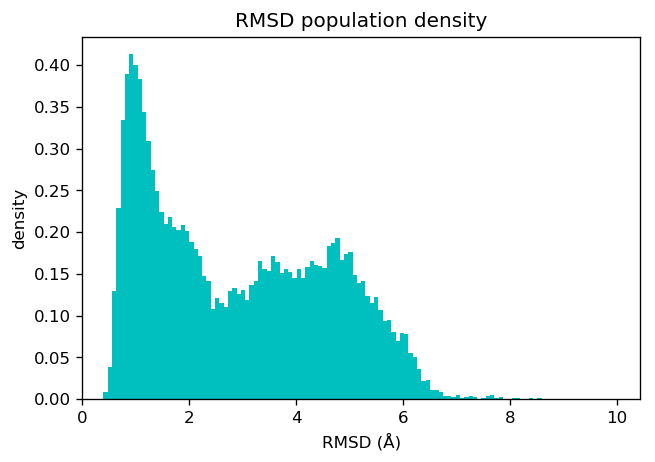

In [7]:
plt.figure(dpi=120)
plt.title('RMSD population density')
plt.ylabel('density')
plt.xlabel('RMSD (Å)')
plt.hist(df['rmsd'], color='c', bins=125, normed=True)
plt.xlim(0, df['rmsd'].max())
    
    
plt.show()